In [4]:
import torch as t
from scipy import ndimage
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [5]:
#device = t.device('cuda' if t.cuda.is_available() else 'cpu')
device = t.device('cpu')

In [6]:
def simple_res_plot(temps, grads, losses):
    plt.plot(temps.cpu(), grads, label="gradient")
    plt.plot(temps.cpu(), losses, label="loss")
    plt.plot(temps.cpu(), t.sigmoid(temps).cpu(), label="probability")

    plt.hlines(y=[0.], xmin=-3.0, xmax=3., label="0-grad line", linestyles="dashed", colors=["gray"])

    plt.legend()
    plt.show()

In [7]:
def create_dist_matrix(batch:t.Tensor):
    dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-batch[0].cpu(), return_indices=False)
    dist_matrix = dist_matrix**2
    dist_matrix_t = t.from_numpy(dist_matrix).to(device)
    return dist_matrix_t

In [8]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (0, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)
def get_moore_nbh(batch:t.Tensor):
    _, batch_height, _ = batch.shape
    cell_pixel_coords = (batch == 1).nonzero()
    nbh_coords = (cell_pixel_coords[:, 1:].unsqueeze(1)+MOORE_OFFSETS.type(t.float).unsqueeze(0))
    idx_pad = cell_pixel_coords[:, 0].repeat(9,1).T.reshape(cell_pixel_coords[:, 0].shape[0], 9, 1)
    nbh_coords[nbh_coords == -1] = 1
    nbh_coords[nbh_coords == batch_height] = batch_height -2
    return t.concatenate((idx_pad, nbh_coords), dim=-1)

In [9]:
STEP_SIZES = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)

def MCS(batch, temperature):
    batch_size, batch_height, _ = batch.shape
    
    #########################################################
    # 1. Find source and target coordinates for each sample #
    #########################################################
    # Find all pixels that belong to a cell, or border a cell 
    frontiers = get_moore_nbh(batch)
    src_coords = []
    for batch_idx in range(batch_size):
        frontier = frontiers[frontiers[:, :, 0] == batch_idx, :].unique(dim=0)
        src_coords.append(random.choice(frontier).type(t.long))
    batch_src_coords = t.vstack(src_coords)
    step_sizes = t.vstack(random.choices(STEP_SIZES, k=batch_src_coords.shape[0]))
    tgt_coords = t.hstack((batch_src_coords[:, 0].unsqueeze(0).T, batch_src_coords[:, 1:] + step_sizes))
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = batch_src_coords[:, 0]
    src_j = batch_src_coords[:, 1]
    src_k = batch_src_coords[:, 2]
    
    #########################################################################
    # 2. Calculate the changes in volume that the copy attempts would cause #
    #########################################################################
    current_volumes = t.sum(batch, dim=(-1, -2))
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    adjusted_vols = current_volumes + vol_changes
    
    #########################################################
    # 3. Define boolean masks based on the volume changes   #
    #########################################################
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    vol_change_positive_mask = vol_changes > 0
    vol_change_negative_mask = vol_changes < 0
    
    #########################################################
    # 4. auto accept each attempt with negative vol. change #
    # that fulfills the hard volume constraint              #
    #########################################################
    auto_upd_mask = t.logical_and(
        vol_change_negative_mask,
        greater_zero_mask
    )
    auto_upd_i = tgt_i[auto_upd_mask]
    auto_upd_j = tgt_j[auto_upd_mask]
    auto_upd_k = tgt_k[auto_upd_mask]
    batch[auto_upd_i, auto_upd_j, auto_upd_k] += vol_changes[auto_upd_mask]
    
    ##################################################################
    # 5. stochastic update of the attempts with positive vol. change #
    ################################################################## 
    update_mask = t.logical_and(
        vol_change_positive_mask,
        sml_eq_two_mask
    )
    update_probability = t.sigmoid(temperature)
    #print(update_probability)
    logit = t.log(t.hstack((update_probability, (1-update_probability))))
    batch_logits = logit.repeat((vol_changes[update_mask].shape[0],1))
    one_hot = t.nn.functional.gumbel_softmax(batch_logits, hard=True)
    
    upd_vals = one_hot[:, 0] * vol_changes[update_mask]
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch
    

In [20]:
STEP_SIZES = t.tensor([(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)], device=device)
def MCS(batch, temperature):
    batch_size, batch_height, _ = batch.shape
    
    #########################################################
    # 1. Find source and target coordinates for each sample #
    #########################################################
    # Find all pixels that belong to a cell, or border a cell 
    frontiers = get_moore_nbh(batch)
    src_coords = []
    for batch_idx in range(batch_size):
        frontier = frontiers[frontiers[:, :, 0] == batch_idx, :].unique(dim=0)
        src_coords.append(random.choice(frontier).type(t.long))
    batch_src_coords = t.vstack(src_coords)
    p_f = np.sqrt(2.)
    p_side = (p_f - 1)*p_f/4
    p_diag = (p_f - 1)/4
    step_size_idx = t.tensor(np.random.choice(
            STEP_SIZES.shape[0],
            size=batch_src_coords.shape[0],
            replace=True,
            p=[p_side, p_side, p_side, p_side, p_diag, p_diag, p_diag, p_diag])).type(t.long)
    step_sizes = STEP_SIZES[step_size_idx]
    tgt_coords = t.hstack((batch_src_coords[:, 0].unsqueeze(0).T, batch_src_coords[:, 1:] + step_sizes))
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = batch_src_coords[:, 0]
    src_j = batch_src_coords[:, 1]
    src_k = batch_src_coords[:, 2]
    
    #########################################################################
    # 2. Calculate the changes in volume that the copy attempts would cause #
    #########################################################################
    current_volumes = t.sum(batch, dim=(-1, -2))
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    adjusted_vols = current_volumes + vol_changes
    
    #########################################################
    # 3. Define boolean masks based on the volume changes   #
    #########################################################
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    vol_change_positive_mask = vol_changes > 0
    vol_change_negative_mask = vol_changes < 0
    
    #########################################################
    # 4. auto accept each attempt with negative vol. change #
    # that fulfills the hard volume constraint              #
    #########################################################
    auto_upd_mask = t.logical_and(
        vol_change_negative_mask,
        greater_zero_mask
    )
    auto_upd_i = tgt_i[auto_upd_mask]
    auto_upd_j = tgt_j[auto_upd_mask]
    auto_upd_k = tgt_k[auto_upd_mask]
    batch[auto_upd_i, auto_upd_j, auto_upd_k] += vol_changes[auto_upd_mask]
    
    ##################################################################
    # 5. stochastic update of the attempts with positive vol. change #
    ################################################################## 
    update_mask = t.logical_and(
        vol_change_positive_mask,
        sml_eq_two_mask
    )
    update_probability = t.exp(-temperature)
    logit = t.log(t.hstack((update_probability, (1-update_probability))))
    batch_logits = logit.repeat((vol_changes[update_mask].shape[0],1))
    one_hot = t.nn.functional.gumbel_softmax(batch_logits, hard=True)
    
    upd_vals = one_hot[:, 0] * vol_changes[update_mask]
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch
    

In [10]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, eta:float, num_steps:int, target_distance:float):
    for i in tqdm(range(num_steps)):
        batch = MCS(batch, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 100 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    print(f"temperature: {temperature}, update_prob:{t.sigmoid(temperature)} mean distance: {mean_distance}")
    loss = (mean_distance - target_distance)**2
    grad = t.autograd.grad(loss, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - (eta * grad), min=1e-5, max=40.), grad, mean_distance, loss

In [13]:
temps = t.linspace(-3,3,30)
ref = t.zeros(1,16,16, device=device)
ref[:,8,8] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 2.

grads = []
mean_distances = []
losses = []
for temp in temps:
    temp.requires_grad_()
    batch = t.zeros(1000,16,16, device=device)
    batch[:,8,8] += 1
    new_temp, grad, mean_distance, loss = step(batch, dist_matrix, temp, eta=1, num_steps=100, target_distance=target_distance)
    grads.append(grad.detach().cpu().numpy())
    mean_distances.append(mean_distance.detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())

100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


temperature: -3.0, update_prob:0.04742587357759476 mean distance: 0.395
gradient: -2.729947566986084


100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


temperature: -2.7931034564971924, update_prob:0.05769799277186394 mean distance: 0.4745
gradient: -2.7370009422302246


100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


temperature: -2.5862069129943848, update_prob:0.07003141194581985 mean distance: 0.549
gradient: -2.644878387451172


100%|██████████| 100/100 [00:18<00:00,  5.26it/s]


temperature: -2.379310369491577, update_prob:0.08476405590772629 mean distance: 0.6675
gradient: -2.474626064300537


100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


temperature: -2.1724138259887695, update_prob:0.10225523263216019 mean distance: 0.8335
gradient: -2.1945571899414062


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


temperature: -1.9655171632766724, update_prob:0.12287120521068573 mean distance: 0.936
gradient: -1.958207130432129


100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


temperature: -1.7586206197738647, update_prob:0.1469631791114807 mean distance: 1.0535
gradient: -1.6012587547302246


100%|██████████| 100/100 [00:19<00:00,  5.15it/s]


temperature: -1.5517240762710571, update_prob:0.1748373955488205 mean distance: 1.2215
gradient: -1.2433335781097412


100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


temperature: -1.3448275327682495, update_prob:0.20671729743480682 mean distance: 1.485
gradient: -0.6921135783195496


100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


temperature: -1.137930989265442, update_prob:0.24270041286945343 mean distance: 1.6445
gradient: -0.4213044047355652


100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


temperature: -0.9310344457626343, update_prob:0.2827149033546448 mean distance: 2.0055
gradient: 0.004158674739301205


100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


temperature: -0.7241378426551819, update_prob:0.3264824450016022 mean distance: 2.23
gradient: 0.14000257849693298


100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


temperature: -0.5172412991523743, update_prob:0.37349751591682434 mean distance: 2.5945
gradient: 0.0700121819972992


100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


temperature: -0.3103446960449219, update_prob:0.4230306148529053 mean distance: 2.6085
gradient: 0.2131580263376236


100%|██████████| 100/100 [00:20<00:00,  4.88it/s]


temperature: -0.10344815254211426, update_prob:0.4741609990596771 mean distance: 3.0925
gradient: -0.3987887501716614


100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


temperature: 0.10344839096069336, update_prob:0.52583909034729 mean distance: 2.936
gradient: -0.0711488127708435


100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


temperature: 0.3103446960449219, update_prob:0.5769694447517395 mean distance: 3.362
gradient: -0.34184879064559937


100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


temperature: 0.5172412395477295, update_prob:0.6265023946762085 mean distance: 3.3995
gradient: -0.35512030124664307


100%|██████████| 100/100 [00:20<00:00,  4.81it/s]


temperature: 0.7241377830505371, update_prob:0.6735175251960754 mean distance: 3.4475
gradient: -0.23171868920326233


100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


temperature: 0.9310343265533447, update_prob:0.7172850966453552 mean distance: 3.97
gradient: -0.6258020997047424


100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


temperature: 1.137930989265442, update_prob:0.757299542427063 mean distance: 4.087
gradient: -0.6859262585639954


100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


temperature: 1.3448275327682495, update_prob:0.7932827472686768 mean distance: 4.1615
gradient: -0.5827761888504028


100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


temperature: 1.5517240762710571, update_prob:0.8251625895500183 mean distance: 4.258
gradient: -0.5720805525779724


100%|██████████| 100/100 [00:21<00:00,  4.71it/s]


temperature: 1.7586206197738647, update_prob:0.8530368208885193 mean distance: 4.172
gradient: -0.33361220359802246


100%|██████████| 100/100 [00:21<00:00,  4.75it/s]


temperature: 1.9655171632766724, update_prob:0.8771287798881531 mean distance: 4.562
gradient: -0.41180652379989624


100%|██████████| 100/100 [00:21<00:00,  4.72it/s]


temperature: 2.1724138259887695, update_prob:0.8977447748184204 mean distance: 4.356
gradient: -0.185653418302536


100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


temperature: 2.379310369491577, update_prob:0.9152359366416931 mean distance: 4.5245
gradient: -0.3288518786430359


100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


temperature: 2.5862069129943848, update_prob:0.9299685955047607 mean distance: 4.6805
gradient: -0.35919415950775146


100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


temperature: 2.7931034564971924, update_prob:0.9423019886016846 mean distance: 4.6785
gradient: -0.25592103600502014


100%|██████████| 100/100 [00:21<00:00,  4.64it/s]

temperature: 3.0, update_prob:0.9525741338729858 mean distance: 4.5895
gradient: -0.19924701750278473


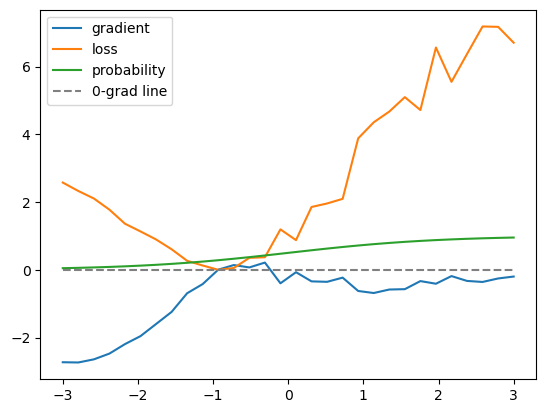

In [18]:
simple_res_plot(temps, grads, losses)

In [36]:
from torchviz import make_dot, make_dot_from_trace
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/jsche/Graphviz/bin/'

temps = t.linspace(-3,3,30)
ref = t.zeros(1,16,16, device=device)
ref[:,8,8] += 1
dist_matrix = create_dist_matrix(ref)
target_distance = 2.
batch = t.zeros(1,16,16, device=device)
batch[:,8,8] += 1    

temperature = t.tensor(1.)
temperature.requires_grad_()
for i in tqdm(range(1)):    
    batch = MCS(batch, temperature)
distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
mean_distance = t.mean(distances)
loss = (mean_distance - target_distance)**2
#grad = t.autograd.grad(loss, temperature)[0]
#make_dot(loss, {"temp": temperature})
dot = make_dot(loss, {"temp": temperature})
dot.render("compgraph_1_1", format="dot")

100%|██████████| 1/1 [00:00<00:00, 501.47it/s]


'compgraph_1_1.dot'

In [34]:
dot.render("compgraph_c10", format="png")

'compgraph_c10.png'